### Predicting Illiquid Stock Prices using data 

1. Open Anaconda prompt
2. cd into project folder
3. conda env create --file environment.yaml
4. conda activate berkeley_env



In [56]:
import pandas as pd
import numpy as np
import os 
import glob
import seaborn as sns
import pickle
import matplotlib.pyplot as plt
import shap

In [57]:
from sklearn.ensemble import RandomForestRegressor
from sklearn.preprocessing import MinMaxScaler, StandardScaler
from sklearn.model_selection import train_test_split

### Load and Format Data


In [58]:
# financial ratios data for energy companies
# @S&P Global
ratio = pd.read_csv("fundamental_data/energy_ratios.csv")
# historical stock prices - 
# @Yahoo Finance API via yfinance Python package
prices_full = pd.read_csv('stock_prices/prices_y_finance_full.csv')


In [59]:
# historical ETF data for top market indexes
# @https://www.kaggle.com/datasets/borismarjanovic/price-volume-data-for-all-us-stocks-etfs
mkt_files = glob.glob("market_data/*.txt")
mkt_indexes = pd.concat((pd.read_csv(f).tail(1000).assign(Ticker = f.replace("market_data/", '')
                                                          .replace('.us.txt', '')) for f in mkt_files), 
                                                           ignore_index=True)

In [60]:
mkt_indexes['Date'] = pd.to_datetime(mkt_indexes['Date']) 

In [61]:
prices_full['Date'] = pd.to_datetime(prices_full['Date'], utc=True)
prices_full['Date'] = prices_full['Date'].dt.floor('D')
prices_full['Date']  = prices_full['Date'].dt.tz_localize(None)
prices_full = prices_full.rename(columns={'Close':'price'})

In [62]:
prices_cols = ['Date', 'Ticker', 'price']

In [63]:
ratio = ratio.rename(columns={'EXCHANGE TICKER SYMBOL - HISTORICAL': 'Ticker'})
ratio['Public Date'] = pd.to_datetime(ratio['Public Date'].astype('str'))
ratio = ratio.drop(columns=['Unnamed: 0'])
ratio = ratio.rename(columns={'Public Date':'quarter_date'})

In [64]:
ratio_dates = ratio.quarter_date.unique()

#### Inspect financial ratio data

In [65]:
ratio.head()

,CRSP PERMNO,Fiscal year end,Fiscal quarter end,quarter_date,Enterprise Value Multiple,"P/E (Diluted, Excl. EI)",Price/Cash flow,Net Profit Margin,Operating Profit Margin Before Depreciation,Cash Flow Margin,...,Free Cash Flow/Operating Cash Flow,Total Liabilities/Total Tangible Assets,Total Debt/Capital,Total Debt/Equity,Cash Ratio,Quick Ratio (Acid Test),Price/Book,Trailing P/E to Growth (PEG) ratio,Dividend Yield,Ticker
0,10211,2004-12-31 00:00:00,2005-09-30 00:00:00,2006-01-31,25.954657,14.690021,5.887037,0.170405,0.397489,0.180422,...,0.989249,195.813876,0.910005,10.256291,NaN,NaN,2.362576,0.415521,0.008672,WES
1,10211,2005-12-31 00:00:00,2005-12-31 00:00:00,2006-02-28,27.245499,14.783951,2.083309,0.170778,0.402913,NaN,...,NaN,203.262623,0.903453,9.485602,NaN,NaN,2.347888,0.440440,0.017815,WES
2,10353,2005-03-31 00:00:00,2005-09-30 00:00:00,2006-01-31,-25.748228,-24.177778,-28.729489,-0.717752,-0.090556,-0.576822,...,NaN,7.714005,0.375466,0.840340,3.146897,3.914752,1.673792,NaN,NaN,ADPT
3,10353,2005-03-31 00:00:00,2005-12-31 00:00:00,2006-02-28,-32.483237,-25.761317,52.485545,-0.799512,-0.068569,-0.687169,...,0.037265,8.489389,0.407996,0.945784,3.295638,3.965693,2.016746,NaN,NaN,ADPT
4,10353,2005-03-31 00:00:00,2005-12-31 00:00:00,2006-03-31,-32.483237,-22.757202,45.237870,-0.799512,-0.068569,-0.687169,...,0.037265,8.489389,0.407996,0.945784,3.295638,3.965693,1.738256,NaN,NaN,ADPT


In [66]:
def filter_max_dates(row):
    return max(ratio_dates[np.where(row['Date'] > ratio_dates)])
    

#### Since financial ratio data is quarterly and market index data is daily, we want to match them up appropriately

In [67]:
mkt_indexes['quarter_date'] = mkt_indexes.apply(filter_max_dates, axis=1)

In [68]:
mkt_indexes = pd.pivot_table(mkt_indexes[['Date', 'Close', 'Ticker', 'quarter_date']], values='Close', columns=['Ticker'],
              index=['Date', 'quarter_date']).reset_index()

In [69]:
financial = pd.merge(mkt_indexes, ratio, how='left', on=['quarter_date'])


In [70]:
financial.head()

,Date,quarter_date,qqq,spy,vgsh,vxx,CRSP PERMNO,Fiscal year end,Fiscal quarter end,Enterprise Value Multiple,...,Free Cash Flow/Operating Cash Flow,Total Liabilities/Total Tangible Assets,Total Debt/Capital,Total Debt/Equity,Cash Ratio,Quick Ratio (Acid Test),Price/Book,Trailing P/E to Growth (PEG) ratio,Dividend Yield,Ticker
0,2013-11-22,2013-10-31,80.171,166.82,59.211,711.2,11478,2012-12-31 00:00:00,2013-06-30 00:00:00,6.858907,...,-0.456226,0.736763,0.644297,2.232299,0.008734,0.499789,1.775126,NaN,0.006702,BRY
1,2013-11-22,2013-10-31,80.171,166.82,59.211,711.2,11644,2012-12-31 00:00:00,2013-06-30 00:00:00,10.835380,...,-0.631756,0.704019,0.570288,1.608883,0.499774,0.437908,0.667808,-0.104265,0.029223,CRK
2,2013-11-22,2013-10-31,80.171,166.82,59.211,711.2,11850,2012-12-31 00:00:00,2013-06-30 00:00:00,6.648812,...,0.286039,0.722032,0.278510,0.994492,0.125594,0.713036,1.928083,0.607711,0.028119,XOM
3,2013-11-22,2013-10-31,80.171,166.82,59.211,711.2,12384,2012-12-31 00:00:00,2013-06-30 00:00:00,26.242468,...,-0.223149,0.965715,0.353046,0.839674,0.440287,1.419639,2.417993,NaN,0.013247,SEMG
4,2013-11-22,2013-10-31,80.171,166.82,59.211,711.2,12476,2012-12-31 00:00:00,2013-06-30 00:00:00,9.090725,...,-1.037994,0.894314,NaN,23.449686,0.159945,0.953597,13.395317,NaN,0.029397,TRGP


#### Inspect a single stock's price over time

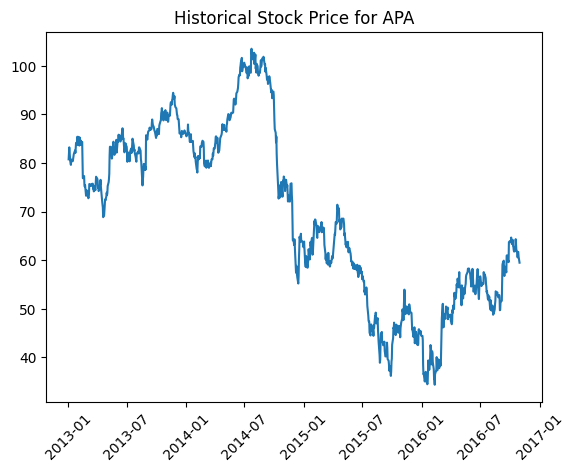

In [71]:
ticker = 'APA'
plt.plot(prices_full[prices_full.Ticker == ticker].Date,prices_full[prices_full.Ticker == ticker].price)
plt.title('Historical Stock Price for {}'.format(ticker))
plt.xticks(rotation=45)
plt.show()


In [72]:
full_dataset = pd.merge(financial, prices_full[prices_cols], how='left', on=['Ticker', 'Date']).dropna(subset=['price'])


#### Inspect data types and missing values

In [73]:
full_dataset.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 74615 entries, 1 to 125469
Data columns (total 33 columns):
 #   Column                                          Non-Null Count  Dtype         
---  ------                                          --------------  -----         
 0   Date                                            74615 non-null  datetime64[ns]
 1   quarter_date                                    74615 non-null  datetime64[ns]
 2   qqq                                             74615 non-null  float64       
 3   spy                                             74615 non-null  float64       
 4   vgsh                                            74615 non-null  float64       
 5   vxx                                             74615 non-null  float64       
 6   CRSP PERMNO                                     74615 non-null  int64         
 7   Fiscal year end                                 74220 non-null  object        
 8   Fiscal quarter end                           

#### Drop sparse features

In [74]:
full_dataset = full_dataset.drop(columns=['Trailing P/E to Growth (PEG) ratio', 'Dividend Yield'])

In [75]:
full_dataset = full_dataset.dropna()
full_dataset = full_dataset.sort_values(by='Date', ascending=True)
full_dataset.shape

(56555, 31)

In [76]:
full_dataset.head()

,Date,quarter_date,qqq,spy,vgsh,vxx,CRSP PERMNO,Fiscal year end,Fiscal quarter end,Enterprise Value Multiple,...,Cash Flow/Total Debt,Free Cash Flow/Operating Cash Flow,Total Liabilities/Total Tangible Assets,Total Debt/Capital,Total Debt/Equity,Cash Ratio,Quick Ratio (Acid Test),Price/Book,Ticker,price
1,2013-11-22,2013-10-31,80.171,166.82,59.211,711.2,11644,2012-12-31 00:00:00,2013-06-30 00:00:00,10.835380,...,0.160521,-0.631756,0.704019,0.570288,1.608883,0.499774,0.437908,0.667808,CRK,89.099998
100,2013-11-22,2013-10-31,80.171,166.82,59.211,711.2,80926,2012-12-31 00:00:00,2013-06-30 00:00:00,5.346684,...,0.307923,-1.629168,0.598526,0.424717,0.811122,0.111033,0.585282,0.998569,CPE,66.099998
96,2013-11-22,2013-10-31,80.171,166.82,59.211,711.2,79857,2012-12-31 00:00:00,2013-06-30 00:00:00,3.924699,...,0.524638,0.110492,0.526882,0.247729,0.712351,0.330268,1.905451,0.968227,PTEN,23.700001
92,2013-11-22,2013-10-31,80.171,166.82,59.211,711.2,79066,2012-12-31 00:00:00,2013-06-30 00:00:00,-178.545045,...,0.085817,0.718699,0.528242,0.271109,0.891760,1.574189,2.143547,0.488607,GBR,2.120000
91,2013-11-22,2013-10-31,80.171,166.82,59.211,711.2,79039,2012-12-31 00:00:00,2013-06-30 00:00:00,30.732353,...,0.536665,-0.545961,0.226761,0.100318,0.215506,0.249620,1.902782,0.727034,USEG,205.800003


#### Filter out outlier stock prices

In [77]:
full_dataset = full_dataset[full_dataset.price < 1000]

In [78]:
mkt_features = ['qqq', 'spy', 'vgsh', 'vxx']

In [79]:
fundamental_features = ['Enterprise Value Multiple',
       'P/E (Diluted, Excl. EI)', 'Price/Cash flow', 'Net Profit Margin',
       'Operating Profit Margin Before Depreciation', 'Cash Flow Margin',
       'Total Debt/Invested Capital', 'Interest/Average Total Debt',
       'Cash Balance/Total Liabilities', 'Total Debt/EBITDA',
       'Profit Before Depreciation/Current Liabilities',
       'Operating CF/Current Liabilities', 'Cash Flow/Total Debt',
       'Free Cash Flow/Operating Cash Flow',
       'Total Liabilities/Total Tangible Assets', 'Total Debt/Capital',
       'Total Debt/Equity', 'Cash Ratio', 'Quick Ratio (Acid Test)',
       'Price/Book']

In [80]:
features = mkt_features + fundamental_features


In [81]:
target = 'price'

### EDA

#### Analyze market indexes

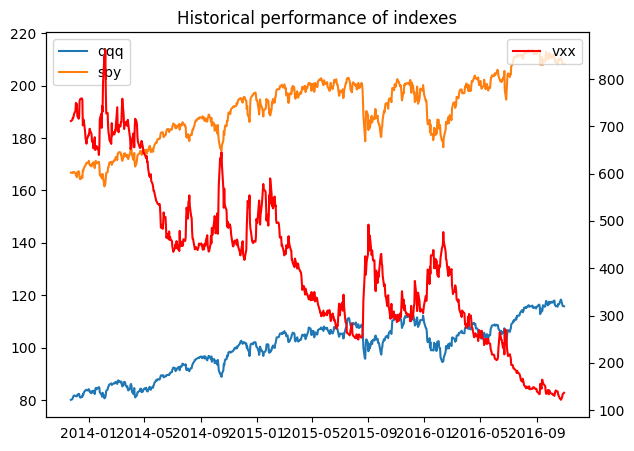

In [82]:
fig, ax1 = plt.subplots(figsize=(7, 5))
ax2 = ax1.twinx()
for mkt_col in ['qqq', 'spy']:
    ax1.plot(full_dataset['Date'], full_dataset[mkt_col], label=mkt_col)
ax2.plot(full_dataset['Date'], full_dataset['vxx'], label='vxx', c='r')
plt.title('Historical performance of indexes')
ax1.legend()
ax2.legend()
plt.show()

#### Appears that features 'spy' (S&P 500 index) and 'qqq' (NASDAQ 100 index) are correlated

Removing correlated features is important to prevent the model from assigning too much importance to, in essence, the same variable.

<AxesSubplot: >

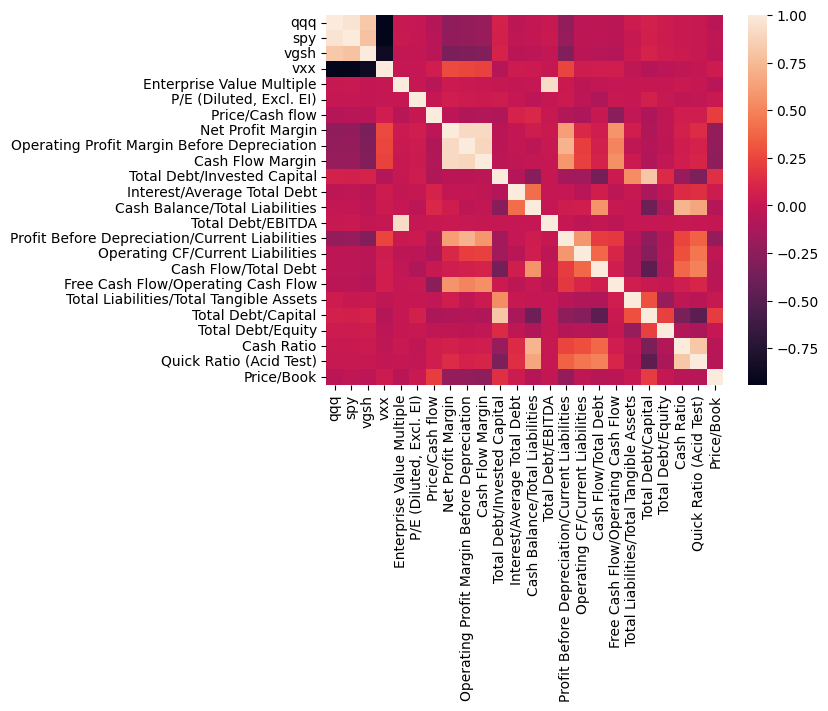

In [83]:
sns.heatmap(full_dataset[features].corr())

In [84]:
correlated_features = ['Enterprise Value Multiple', 'Quick Ratio (Acid Test)', 'qqq', 'Net Profit Margin', 
                       'Operating Profit Margin Before Depreciation']


In [85]:
for i in range(len(correlated_features)):
    features.remove(correlated_features[i])
features_df = full_dataset[features]
target_df = full_dataset[target]

### Prepare data for modeling

#### Normal way to split data: random split

In [86]:
X_train, X_test, y_train, y_test = train_test_split(features_df, target_df, test_size=0.2, random_state=5)
print("Train set size: ", len(X_train), "\nTest set size: ", len(X_test))

Train set size:  44752 
Test set size:  11188


#### Why is this a problem?

With time-dependent data, randomly splitting our train/test sets means we can have future data in the train set and past data in the test set.

In our case, this could mean teaching our model to predict the price of stock ABC on a given day using future data. 

This presents a data leakage problem. We want a time series split of our data.

In [87]:
del X_train
del X_test
del y_train
del y_test

### Time Series data split

Lets save the latest 20% of data for testing

In [88]:
cutoff_index = int(0.8 * len(features_df))

In [89]:
X_train, X_test = features_df.iloc[:cutoff_index, :], features_df.iloc[cutoff_index:, :]
y_train, y_test = target_df.iloc[:cutoff_index], target_df.iloc[cutoff_index:]

### Normalizing data for training

We want to fit the normalizer only on the train set and apply that scaler to both. This prevents data leakage from train to test sets.

In [90]:
ss = StandardScaler()
X_train = pd.DataFrame( # turning scaled output (np.Array) back into DataFrame
          ss.fit_transform(X_train),
          columns=X_train.columns,
          index=X_train.index
          )
            

In [91]:
X_test = pd.DataFrame( # turning scaled output (np.Array) back into DataFrame
         ss.transform(X_test),
         columns=X_test.columns,
         index=X_test.index
         )

### Occam's Razor - can we solve this problem with a simpler model?

In [92]:
class LinearRegressor:
    
    def __init__(self):
        self.w = None
        
    def fit(self, X, y):
        self.w = (np.linalg.inv(X.T @ X) @ X.T @ y)[:, np.newaxis]
    
    def predict(self, X):
        return (X @ self.w)[0]
    
    def get_weights(self):
        return self.w.round(4)
    

#### Fit Linear Regression 

In [93]:
linreg = LinearRegressor()
linreg.fit(X_train, y_train)

Support for multi-dimensional indexing (e.g. `obj[:, None]`) is deprecated and will be removed in a future version.  Convert to a numpy array before indexing instead.


In [94]:
# out-of-sample prediction
lin_preds = linreg.predict(X_test)
np.mean(abs(lin_preds - y_test))

68.8567539848556

In [42]:
full_dataset[['Ticker', 'Date']]

,Ticker,Date
1,CRK,2013-11-22
100,CPE,2013-11-22
96,PTEN,2013-11-22
92,GBR,2013-11-22
91,USEG,2013-11-22
...,...,...
125366,HAL,2016-10-31
125365,CNP,2016-10-31
125364,EXC,2016-10-31
125356,MRO,2016-10-31


In [43]:
full_dataset.iloc[cutoff_index:, :].loc[:, ['Ticker', 'Date']]

,Ticker,Date
100252,CVX,2016-03-21
100235,SLCA,2016-03-21
100233,REGI,2016-03-21
100231,LPI,2016-03-21
100228,MPC,2016-03-21
...,...,...
125366,HAL,2016-10-31
125365,CNP,2016-10-31
125364,EXC,2016-10-31
125356,MRO,2016-10-31


#### Spot checking Linear Regression predictions

In [95]:
y_test_df = pd.DataFrame(y_test.round(3))

In [96]:
compare_preds = pd.concat([full_dataset.iloc[cutoff_index:, :].loc[:, ['Ticker', 'Date']], 
                           pd.DataFrame(lin_preds.round(3)), 
                           y_test_df], 
                           axis=1)
compare_preds.columns = ['ticker', 'date', 'predicted price', 'true price']
compare_preds

,ticker,date,predicted price,true price
100252,CVX,2016-03-21,-1.020,96.440
100235,SLCA,2016-03-21,-15.312,22.520
100233,REGI,2016-03-21,-7.578,8.930
100231,LPI,2016-03-21,-107.062,8.820
100228,MPC,2016-03-21,-8.344,38.420
...,...,...,...,...
125366,HAL,2016-10-31,-33.041,46.000
125365,CNP,2016-10-31,-21.577,22.800
125364,EXC,2016-10-31,-16.928,24.301
125356,MRO,2016-10-31,-11.187,13.180


#### Inspect linear regression weights

In [46]:
pd.DataFrame(zip(features, linreg.get_weights()), columns=['feature', 'weight'])

,feature,weight
0,spy,[2.7784]
1,vgsh,[-8.8953]
2,vxx,[-0.5909]
3,"P/E (Diluted, Excl. EI)",[1.5947]
4,Price/Cash flow,[3.1106]
5,Cash Flow Margin,[-0.52]
6,Total Debt/Invested Capital,[5.3835]
7,Interest/Average Total Debt,[2.7057]
8,Cash Balance/Total Liabilities,[-17.2202]
9,Total Debt/EBITDA,[-0.6961]


### More powerful modeling

In [97]:
params = {"n_estimators": 50,
          "max_depth": 5,
          "max_features": 0.7}

In [98]:
rf = RandomForestRegressor(**params)
rf.fit(X_train, y_train)

RandomForestRegressor(max_depth=5, max_features=0.7, n_estimators=50)

In [99]:
predictions_rf = rf.predict(X_test)

In [100]:
# out-of-sample prediction
np.mean(abs(predictions_rf - y_test))

33.49489102326995

#### Spot checking Random Forest predictions

In [101]:
compare_preds = pd.concat([full_dataset.iloc[cutoff_index:, :].loc[:, ['Ticker', 'Date']], 
                           pd.DataFrame(predictions_rf.round(3), index=y_test_df.index), 
                           y_test_df], 
                           axis=1)
compare_preds.columns = ['ticker', 'date', 'predicted price', 'true price']
compare_preds

,ticker,date,predicted price,true price
100252,CVX,2016-03-21,69.730,96.440
100235,SLCA,2016-03-21,34.991,22.520
100233,REGI,2016-03-21,23.042,8.930
100231,LPI,2016-03-21,34.029,8.820
100228,MPC,2016-03-21,29.317,38.420
...,...,...,...,...
125366,HAL,2016-10-31,30.097,46.000
125365,CNP,2016-10-31,24.871,22.800
125364,EXC,2016-10-31,25.101,24.301
125356,MRO,2016-10-31,81.833,13.180


### Explainable ML

#### Random Forest feature importance

Determines what features were most useful based on how often they were used to form decision trees in forest

<BarContainer object of 19 artists>

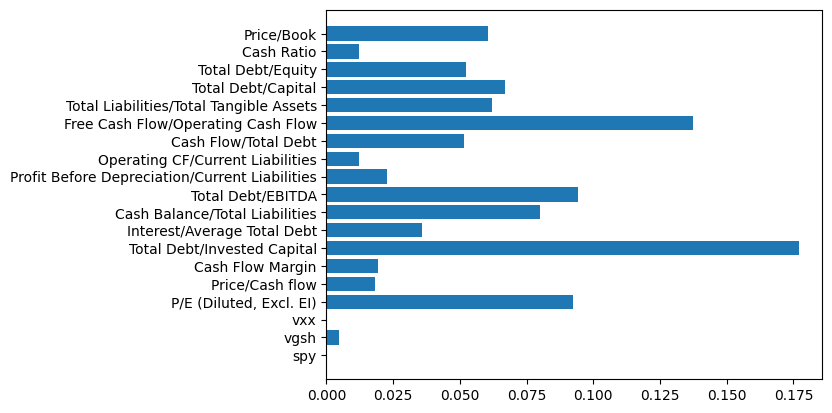

In [102]:
plt.barh(rf.feature_names_in_, rf.feature_importances_)

#### Random Forest Shapley Values

In [51]:
# !! Warning: Takes a long time to run!! Better to read in Shapley from pickle below
explainer = shap.Explainer(rf.predict, X_test)
shap_values = explainer(X_test)

KeyboardInterrupt: 

In [103]:
# read in Shapley values from Pickle
shap_values = pickle.load(open('rf_shap.pkl', 'rb'))

In [104]:
sample_ind = 100

#### Shap values are an intuitive way of representing the impact of features on individual predictions

As a quant in trading, your end users are the traders. It is imperative to translate quantitative solutions and insights to the business problem they are trying to solve.

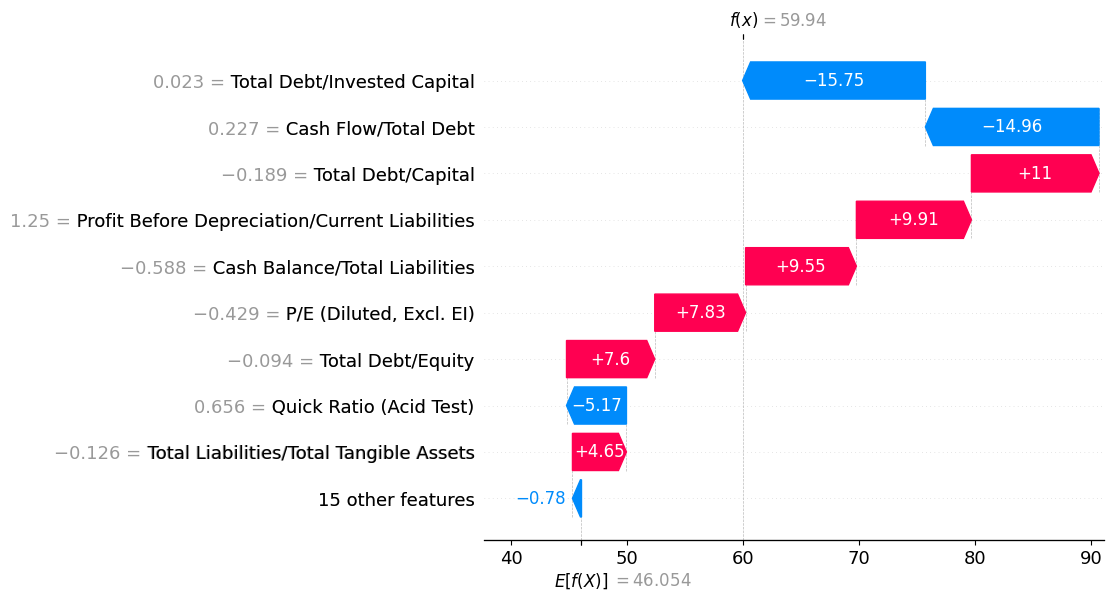

In [105]:
shap.plots.waterfall(shap_values[sample_ind])